In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical  # Only for categorical one hot encoding
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score

In [63]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
cy_train = np.array(to_categorical(y_train))
cy_test = np.array(to_categorical(y_test))

cx_train, cx_test = np.array((x_train.reshape(x_train.shape[0], 28, 28, 1) - 127.5)/127.5), np.array((x_test.reshape(x_test.shape[0], 28, 28, 1)-127.5)/127.5)
cx_train.shape

(60000, 28, 28, 1)

In [67]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)#, reduction=tf.keras.losses.Reduction.SUM)

def discriminator_loss(real_output, fake_output, smooth=1):
    real_loss = cross_entropy(tf.ones_like(real_output) * smooth, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # total_loss = tf.concat((fake_loss, real_loss), axis=0)
    total_loss = (fake_loss + real_loss) * 0.5
    return total_loss #* 0.5
    
def wasserstein_discriminator_loss(real_output, fake_output):
    total_loss = -tf.reduce_mean(real_output - fake_output)
    return total_loss

def generator_loss(fake_output, smooth=1):
    return cross_entropy(tf.ones_like(fake_output) * smooth, fake_output)

def wasserstein_generator_loss(fake_output):
    total_loss = -tf.reduce_mean(fake_output)
    return total_loss

def generator_enc_loss(real, fake):
  # return tf.reduce_mean(tf.abs(real - fake))
  return tf.keras.losses.mean_absolute_error(real, fake)

In [68]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(512, use_bias=False, input_shape=(128,)))
    model.add(layers.Dense(7*7*256, use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (7, 7), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (7, 7), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

def discriminator():
    inputLayer = layers.Input((28, 28, 1))
    x = tf.keras.layers.GaussianNoise(0.01)(inputLayer)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    # x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    # x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    # x = layers.Dropout(0.3)(x)
    print(x.shape)
    x = layers.GlobalAveragePooling2D()(x)
    encOut = x

    clsOut = layers.Dense(10)(x)
    x = layers.Dense(1)(x)

    dis = tf.keras.models.Model(inputs=inputLayer, outputs=x)
    enc = tf.keras.models.Model(inputs=inputLayer, outputs=encOut)
    cls = tf.keras.models.Model(inputs=inputLayer, outputs=clsOut)

    return dis, enc, cls

In [69]:
gen = generator()
des, enc, cls = discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

(None, 4, 4, 128)


In [70]:
def trainDesGenEnc(gen, des, enc, real, batch_size):
  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    noise = enc(real, training=False)
    fake = gen(noise, training=True)
    X = tf.concat((fake, real), axis=0)
    pred = des(X, training=True)

    fake_output = pred[:batch_size]
    real_output = pred[batch_size:]

    des_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(des_loss, des.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, des.trainable_variables))

    gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

# @tf.function
def trainGenEnc(gen, enc, real, batch_size):
  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    real_enc = enc(real, training=False)
    enc_fake = gen(real_enc, training=True)

    gen_loss = generator_enc_loss(real, enc_fake) * 0.5
    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

# @tf.function
def trainDes(gen, des, real, batch_size, smooth):
  with tf.GradientTape() as disc_tape:
    noise = tf.random.normal([batch_size, 128])

    fake = gen(noise, training=False)

    X = tf.concat((fake, real), axis=0)
    
    pred = des(X, training=True)

    fake_output = pred[:batch_size]
    real_output = pred[batch_size:]

    des_loss = discriminator_loss(real_output, fake_output, smooth)
    gradients_of_discriminator = disc_tape.gradient(des_loss, des.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, des.trainable_variables))

# @tf.function
def trainDesGen(gen, des, real, batch_size, smooth):
  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    noise = tf.random.normal([batch_size, 128])
    fake = gen(noise, training=True)
    X = tf.concat((fake, real), axis=0)
    pred = des(X, training=True)

    fake_output = pred[:batch_size]
    real_output = pred[batch_size:]

    des_loss = discriminator_loss(real_output, fake_output, smooth)
    gen_loss = generator_loss(fake_output, smooth)

    gradients_of_discriminator = disc_tape.gradient(des_loss, des.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, des.trainable_variables))

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

# @tf.function
def trainGen(gen, des, batch_size, smooth):
  with tf.GradientTape() as gen_tape:
    noise = tf.random.normal([batch_size, 128])

    fake = gen(noise, training=True)
    fake_output = des(fake, training=False)

    gen_loss = generator_loss(fake_output, smooth)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

def evalGan(gen, des, data, batches, batch_size):
  desAcc = 0
  genLoss = 0
  for i in range(batches):
    real = data[i]
    fake = gen.predict(tf.random.normal([batch_size, 128]))
    X = tf.concat((fake, real), axis=0)

    output = des.predict(X)

    real_output = output[batch_size:]
    fake_output = output[:batch_size]

    labels = tf.reshape(tf.concat((tf.zeros_like(fake_output), tf.ones_like(real_output)), axis=0), [-1])
    output = tf.reshape(output, [-1])
    
    acc = tf.keras.metrics.binary_accuracy(labels, output, threshold=0.5)
    desAcc += acc.numpy()
    # print(acc)
    genLoss += tf.reduce_sum(generator_loss(fake_output)).numpy() / batch_size
  return desAcc / batches, genLoss / batches

def trainGan(realData, labels=None, epochs=10, batch_size=5, loss='mse', smooth=1.):
  realData = np.array(realData).reshape(tuple([-1, batch_size] + list(realData.shape[1:])))
  labels = np.array(labels).reshape(tuple([-1, batch_size] + list(labels.shape[1:])))
  print(realData.shape)
  noise = tf.random.normal([16, 128])
  results = []
  for epoch in range(epochs):
    realData = tf.random.shuffle(realData)
    for iter in range(len(realData)):
      real = realData[iter]
      real = tf.cast(real, tf.float32)

      trainDes(gen, des, real, batch_size, smooth)
      trainGen(gen, des, batch_size, smooth)
      # trainDesGen(gen, des, real, batch_size, smooth)
      # trainGenEnc(gen, enc, real, batch_size)
      # trainDesGenEnc(gen, des, enc, real, batch_size)

    fake = gen.predict(noise)
    print("Evaluating:")
    desAcc, genLoss = evalGan(gen, des, realData, 10, batch_size)
    results.append({'desAcc':desAcc, 'genLoss':genLoss})
    print("Epoch ", epoch, desAcc, genLoss)

    fig = plt.figure(figsize=(4,4))

    for i in range(fake.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(fake[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

(500, 120, 28, 28, 1)
Evaluating:
Epoch  0 0.9545833230018616 0.024738627076148986


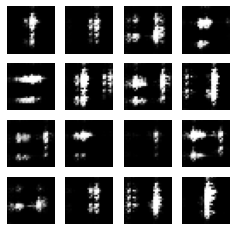

Evaluating:
Epoch  1 0.956250011920929 0.023567277987798053


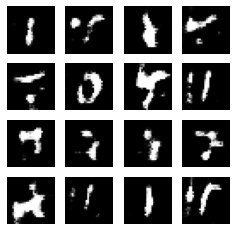

Evaluating:
Epoch  2 0.9233333349227906 0.02405080179373423


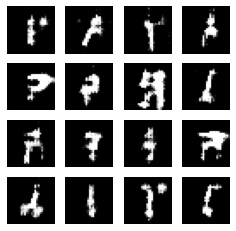

Evaluating:
Epoch  3 0.8625 0.03363981246948242


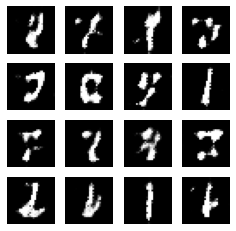

Evaluating:
Epoch  4 0.8354166686534882 0.02609518607457479


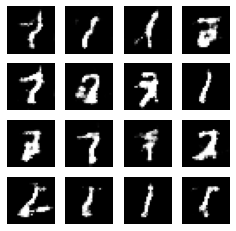

Evaluating:
Epoch  5 0.8500000059604644 0.028328500390052795


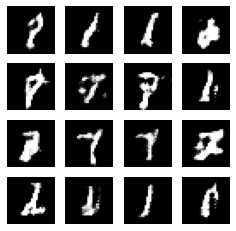

Evaluating:
Epoch  6 0.885833328962326 0.018460679550965624


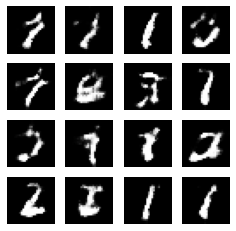

Evaluating:
Epoch  7 0.8591666638851165 0.015273528893788657


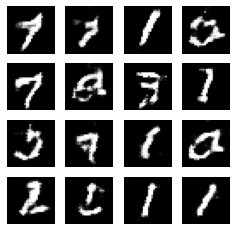

Evaluating:
Epoch  8 0.7737499952316285 0.0077253489693005885


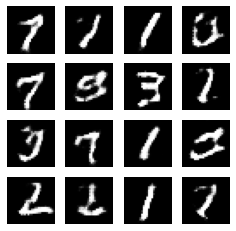

Evaluating:
Epoch  9 0.8691666662693024 0.014661802351474759


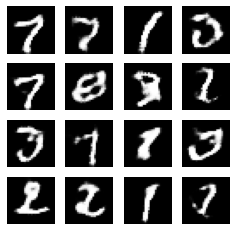

Evaluating:
Epoch  10 0.8179166674613952 0.01902062257130941


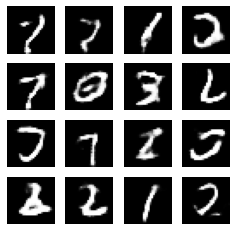

Evaluating:
Epoch  11 0.7416666686534882 0.02194464027881622


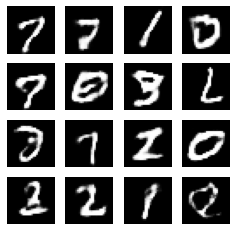

Evaluating:
Epoch  12 0.7662500023841858 0.008019853830337525


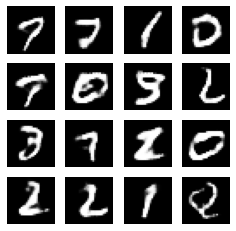

Evaluating:
Epoch  13 0.7545833349227905 0.007001283218463261


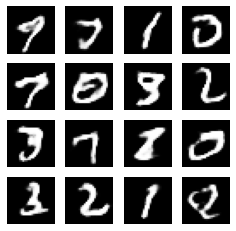

Evaluating:
Epoch  14 0.851666659116745 0.008847016245126724


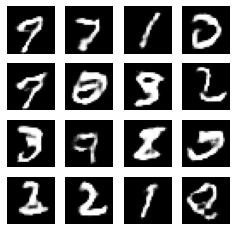

Evaluating:
Epoch  15 0.7058333277702331 0.018593556880950927


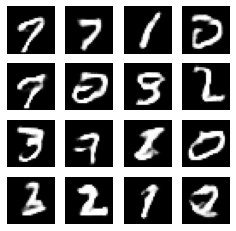

Evaluating:
Epoch  16 0.7970833361148835 0.014798387289047244


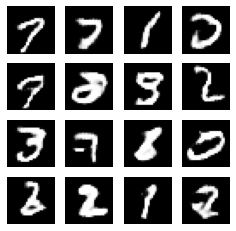

Evaluating:
Epoch  17 0.6704166650772094 0.021932384570439657


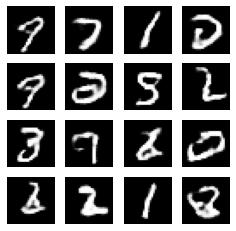

Evaluating:
Epoch  18 0.8399999976158142 0.008982605238755544


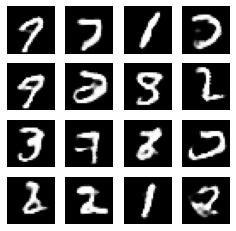

Evaluating:
Epoch  19 0.7350000023841858 0.005174760421117147


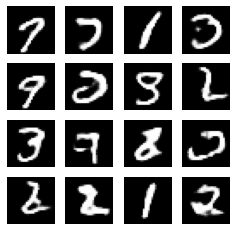

Evaluating:
Epoch  20 0.8225000143051148 0.009077883809804916


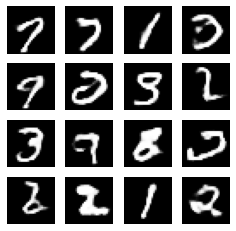

Evaluating:
Epoch  21 0.5229166626930237 0.03469657977422079


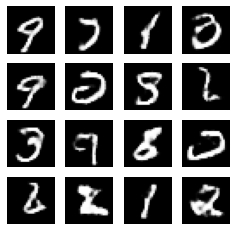

Evaluating:
Epoch  22 0.7858333349227905 0.00770848015944163


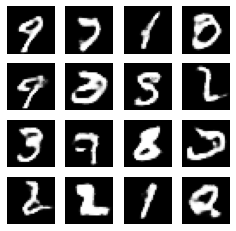

Evaluating:
Epoch  23 0.7195833325386047 0.01560828487078349


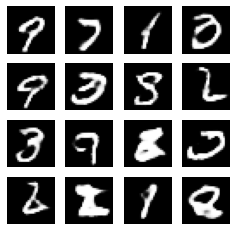

Evaluating:
Epoch  24 0.6116666674613953 0.023767237067222592


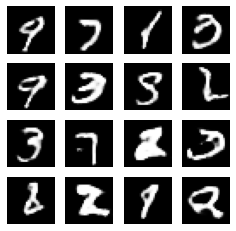

Evaluating:
Epoch  25 0.7879166603088379 0.01404127101103465


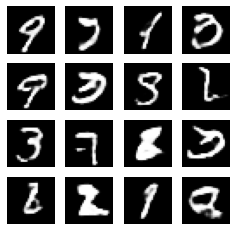

Evaluating:
Epoch  26 0.5475000083446503 0.03055066168308258


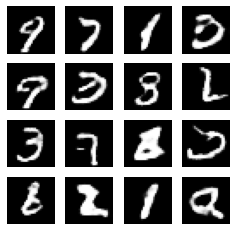

Evaluating:
Epoch  27 0.7783333361148834 0.015371184448401132


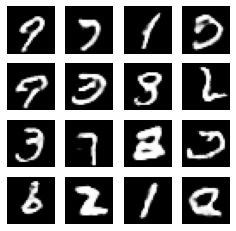

Evaluating:
Epoch  28 0.7004166662693023 0.005261144489049911


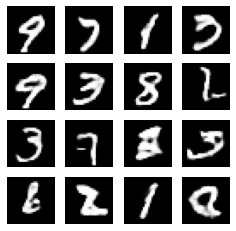

Evaluating:
Epoch  29 0.6320833265781403 0.023134596149126687


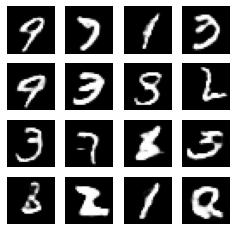

Evaluating:
Epoch  30 0.5416666686534881 0.032859913508097326


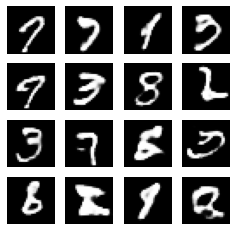

Evaluating:
Epoch  31 0.7987499952316284 0.008792902380228044


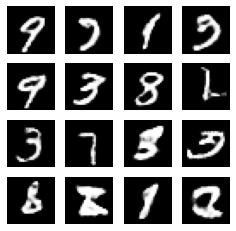

Evaluating:
Epoch  32 0.5183333218097687 0.038493369817733755


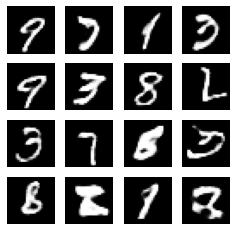

Evaluating:
Epoch  33 0.8487500131130219 0.017797292768955232


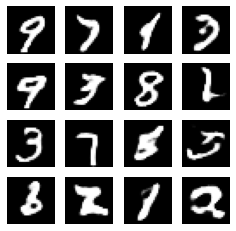

Evaluating:
Epoch  34 0.826666659116745 0.012884178658326468


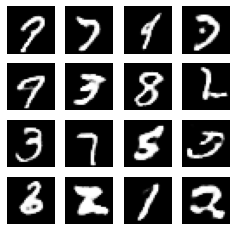

Evaluating:
Epoch  35 0.6037499964237213 0.02907566368579864


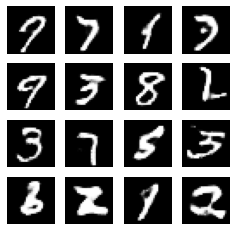

Evaluating:
Epoch  36 0.575 0.0022717352459828057


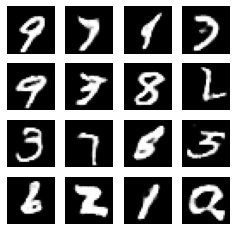

Evaluating:
Epoch  37 0.75 0.006269047260284423


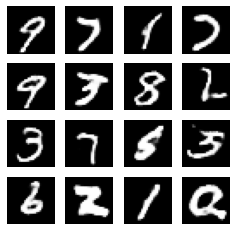

Evaluating:
Epoch  38 0.8004166662693024 0.009715684851010641


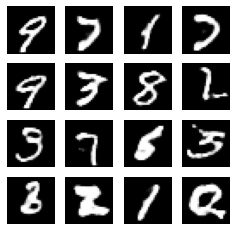

Evaluating:
Epoch  39 0.8845833241939545 0.01642599016427994


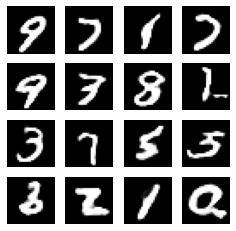

In [ ]:
trainGan(cx_train, cy_train, epochs=100, batch_size=120, smooth=0.95)